# XXCygni - Photometry

**juliaroquette@16September2020**: I am doing some examples of aperture photometry with `photutils` using a couple of different approaches. 

1. I am reading the `fits`, getting headers, etc.

2. I am plotting the image

3. I am importing WCS info from an image I processed online with astrometry.net. Initially, I am showing the use of WCS by adding sky coordinate axis to the image plots. 

4. I am extracting aperture photometry with various approaches:

 4.1 By using `photutils` to model the background in the whole image, using a small box of a few pixels and a median background estimator. 
  
   4.1.1 Using the background estimated, I am using a source extractor function to identify sources in the image, and then perform aperture photometry at the position of these sources. 
  
   4.1.2 Instead of doing source extraction, I am inputting a list of bright stars (that include XXCygni) that I retreive from the APASS database. 
  
 4.2 By using a local background extraction with an annulus around the star
  
  4.2.1 Using a simple mean background value
  
  4.2.2 Using a more robust estimation with a sigma-clipped median. This might be usefull in the extended experiment, when the clusters observed can be more crowded than this XXCygni field
  
  4.2.3 Re-doing 4.2.1 but estimating uncertainties. 
  

TO DO:

1. A Tutorial that teaches how to input one of the aligned images at astrometry.net and finds an astrometric solution for it. 

2. A loop using 4.2.3 that extracts photometry over all the images for XXCygni

**juliaroquette@12August2020** Initial steps towards performing photometry in the XXCygni data.

I am using astrometry.net to get the WCS solution for the first image. 

In [1]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt

These are the directories containing the data and processed images.

In [2]:
mymasterdir='/Users/jroquette/work/prog/jupyter/teaching/AstroLab/2018-10-01/'
workingdir = "working/"

The images were processed in terms of flat fields as in `XXCygni_FlatField.ipynb` and then they were aligned using Tom's prescription as in `XXCygny_aligning.ipynb`. Note from the output below that the flat-fielded images have a `f_` at the beginning of their names, while the aligned images have an `a_` at the begining. 

In [3]:
import glob
file_list = glob.glob(mymasterdir+workingdir+"*fits")
file_list

['/Users/jroquette/work/prog/jupyter/teaching/AstroLab/2018-10-01/working/wcs_CCD_Image_0118.fits',
 '/Users/jroquette/work/prog/jupyter/teaching/AstroLab/2018-10-01/working/rmedian_combined_0_1s.fits',
 '/Users/jroquette/work/prog/jupyter/teaching/AstroLab/2018-10-01/working/new-image_CCD_Image_0118.fits',
 '/Users/jroquette/work/prog/jupyter/teaching/AstroLab/2018-10-01/working/aligned_cube.fits',
 '/Users/jroquette/work/prog/jupyter/teaching/AstroLab/2018-10-01/working/CalibratedImage_test.fits',
 '/Users/jroquette/work/prog/jupyter/teaching/AstroLab/2018-10-01/working/gmedian_combined_0_1s.fits',
 '/Users/jroquette/work/prog/jupyter/teaching/AstroLab/2018-10-01/working/test.fits',
 '/Users/jroquette/work/prog/jupyter/teaching/AstroLab/2018-10-01/working/f_CCD_Image_0636.fits',
 '/Users/jroquette/work/prog/jupyter/teaching/AstroLab/2018-10-01/working/f_CCD_Image_0266.fits',
 '/Users/jroquette/work/prog/jupyter/teaching/AstroLab/2018-10-01/working/f_CCD_Image_0773.fits',
 '/Users/jro

In [4]:
aligned = glob.glob(mymasterdir+workingdir+"a_*fits")
aligned

['/Users/jroquette/work/prog/jupyter/teaching/AstroLab/2018-10-01/working/a_CCD_Image_0636.fits',
 '/Users/jroquette/work/prog/jupyter/teaching/AstroLab/2018-10-01/working/a_CCD_Image_0266.fits',
 '/Users/jroquette/work/prog/jupyter/teaching/AstroLab/2018-10-01/working/a_CCD_Image_0289.fits',
 '/Users/jroquette/work/prog/jupyter/teaching/AstroLab/2018-10-01/working/a_CCD_Image_0773.fits',
 '/Users/jroquette/work/prog/jupyter/teaching/AstroLab/2018-10-01/working/a_CCD_Image_0323.fits',
 '/Users/jroquette/work/prog/jupyter/teaching/AstroLab/2018-10-01/working/a_CCD_Image_0548.fits',
 '/Users/jroquette/work/prog/jupyter/teaching/AstroLab/2018-10-01/working/a_CCD_Image_0118.fits',
 '/Users/jroquette/work/prog/jupyter/teaching/AstroLab/2018-10-01/working/a_CCD_Image_0231.fits',
 '/Users/jroquette/work/prog/jupyter/teaching/AstroLab/2018-10-01/working/a_CCD_Image_0661.fits',
 '/Users/jroquette/work/prog/jupyter/teaching/AstroLab/2018-10-01/working/a_CCD_Image_0724.fits']

### First Image

Let's start by working with the first image in the list. In this section we will:

1. Read the `fits` images
2. Plot the images

3. Read the `WCS` information for the images

4. Use the `photutils` Astropy package to:

    a. Perform source extraction

    b. Estimate and subtract the background
    
    c. Perform apperture photometry
    
 

#### 1. Reading `fits` images:
To open the images, we will use the module `astropy.io.fits`: https://docs.astropy.org/en/stable/io/fits/usage/image.html

In [9]:
import astropy.io.fits as fits

This opens the `fits` image and gets all data units inside it:

In [10]:
aligned[0]

'/Users/jroquette/work/prog/jupyter/teaching/AstroLab/2018-10-01/working/a_CCD_Image_0636.fits'

In [11]:
first=fits.open(aligned[0])

This lists the content of the `fits` file:

In [12]:
first.info()

Filename: /Users/jroquette/work/prog/jupyter/teaching/AstroLab/2018-10-01/working/a_CCD_Image_0636.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      48   (1092, 736)   float64   


This output shows that each `fits` contains only 1 primary data unit (index `0`). 

Let's access these data:

In [13]:
first_data=first[0].data

Note that the image is composed of a grid of pixels presented as a matrix and each element of the matrix contains the counting of photons in that pixel. 

In [14]:
print(first_data.shape)
print(first_data[0])

(736, 1092)
[ 86.57159353 136.13040969 121.14866582 ...  78.55094787 148.26481994
 143.22795341]


This allows us to access the information in the header of the file:

In [15]:
first_head=first[0].header

Note that there are several useful information that will need later. This shows the first 20 lines of the header:

In [16]:
first_head[:]

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1092                                                  
NAXIS2  =                  736                                                  
DATE-OBS= '2018-10-01T22:34:03' /YYYY-MM-DDThh:mm:ss observation start, UT      
EXPTIME =   10.000000000000000 /Exposure time in seconds                        
EXPOSURE=   10.000000000000000 /Exposure time in seconds                        
SET-TEMP=  -20.000000000000000 /CCD temperature setpoint in C                   
CCD-TEMP=  -19.968750000000000 /CCD temperature at start of exposure in C       
XPIXSZ  =   13.600000000000000 /Pixel Width in microns (after binning)          
YPIXSZ  =   13.600000000000000 /Pixel Height in microns (after binning)         
XBINNING=                   

To close the `fits` file:

In [17]:
first.close()

#### 2. Plotting images:

Next, we want to visualize the image we just opened. We can do that using `pyplot`. Here is a raw version of it:

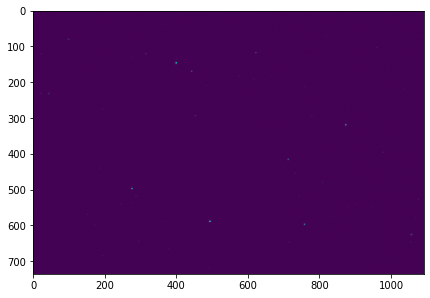

In [18]:
plt.figure(figsize=(7,6))
ax = plt.subplot()
ax.imshow(first_data)

Note that this plot is simply showing the counts in each pixel, plotted in pixel coordinates without taking any consideration for scaling the image or the sky projection. Next, we want to:

#### 3. Add WCS info

To deal with coordinates, we will need the World Coordinate System module (`WCS`) from `astropy`: https://docs.astropy.org/en/stable/wcs/

To add WCS to the images, I went to www.astrometry.net and processed the first image in the list. 

I will use the WCS of the first aligned image to all others.

In [19]:
WCS_name='wcs_CCD_Image_0118.fits'

In [20]:
wcs_fits=fits.open(mymasterdir+workingdir+WCS_name)

In [21]:
wcs_fits.info()

Filename: /Users/jroquette/work/prog/jupyter/teaching/AstroLab/2018-10-01/working/wcs_CCD_Image_0118.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     195   ()      


In [22]:
wcs_header=wcs_fits[0].header

In [23]:
wcs_header

SIMPLE  =                    T / Standard FITS file                             
BITPIX  =                    8 / ASCII or bytes array                           
NAXIS   =                    0 / Minimal header                                 
EXTEND  =                    T / There may be FITS ext                          
WCSAXES =                    2 / no comment                                     
CTYPE1  = 'RA---TAN-SIP' / TAN (gnomic) projection + SIP distortions            
CTYPE2  = 'DEC--TAN-SIP' / TAN (gnomic) projection + SIP distortions            
EQUINOX =               2000.0 / Equatorial coordinates definition (yr)         
LONPOLE =                180.0 / no comment                                     
LATPOLE =                  0.0 / no comment                                     
CRVAL1  =        300.757462194 / RA  of reference point                         
CRVAL2  =        58.9819032472 / DEC of reference point                         
CRPIX1  =        601.1697692

This imports the astropy `WCS` package (https://docs.astropy.org/en/stable/wcs/)

In [24]:
from astropy.wcs import WCS

The information on how to transform pixel coordinate to astronomical ones is contained in the header of the image. For example the keyword `CRVAL1`  tells the RA reference value for a reference pixel `CTYPE1`. The `CD_X` keywords give a transformation matrix and the keyword `CTYPE` tell the projection to be used. 

The `WCS` module will then gather these information from the `fits` header and map the transformation from pixels to real world units:

In [25]:
#help(WCS) #uncomment to see a description of the function

In [26]:
# store its world coordinate system (astronomical coordinates) in a wcs object
wcs_info = WCS(wcs_header)

In [27]:
wcs_info

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 300.757462194  58.9819032472  
CRPIX : 601.169769287  501.612327576  
CD1_1 CD1_2  : 0.000285854666702  2.7288963218e-05  
CD2_1 CD2_2  : -2.71772703808e-05  0.000286067296863  
NAXIS : 0  0

Now that we know the WCS of the image, we can work with things in terms of sky coordinates. For example, we can redo the visualization of the image using them:

This will use some reference Jenny gave to this plot: https://github.com/astropy/astropy/issues/7180

The keyword `projection` informs `pyplot` about the sky project we want to use.

b. Next we deal with the image scale an visualization.

First thing we can do is to add a bettwe color map to improve visualization. This can be done by informing `pyplot` about the color map you want to use with the keyword `cmap`. Here is a reference for the default colormaps available: :https://matplotlib.org/examples/color/colormaps_reference.html

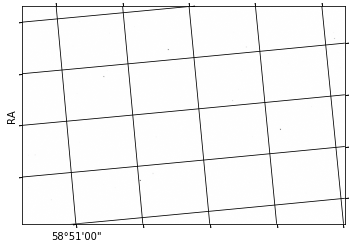

In [28]:
plt.figure(figsize=(7,4))
#This now includes the information about the projection:
ax = plt.subplot(projection=wcs_info)

#
ax.imshow(first_data,cmap='Greys')

#help from https://github.com/astropy/astropy/issues/7180
# the problem is the image has the RA axis 'up' as shown by the CD matrix.
ax.grid(color='black', ls='solid',)

ax.coords['ra'].set_ticklabel_position('l')
ax.coords['dec'].set_ticklabel_position('b')

# RA still refers to the image x axis so switch the labels
ax.coords['ra'].set_axislabel('Dec') 
ax.coords['dec'].set_axislabel('RA')

#This puts the tick labels in the format hms and dms
ax.coords['ra'].set_major_formatter('hh:mm:ss')
ax.coords['dec'].set_major_formatter('dd:mm:ss')

To help finding the best visualization, I will plot a distribution of the counts in the image and estimate its 98.5 and 0.5 percentil:

In [29]:
uplim=np.percentile(first_data.flatten(),98.5)
downlim=np.percentile(first_data.flatten(),0.5)
print(downlim,uplim)

61.86556113920569 176.14662414079098


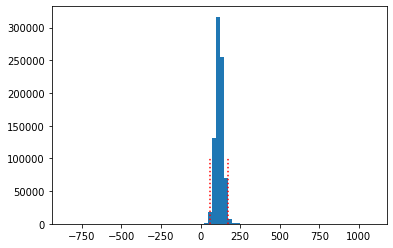

In [30]:
histogram = plt.hist(first_data.flatten(), bins=1000)#'auto')
plt.xlim(downlim-1000,uplim+1000)
plt.plot([uplim,uplim],[0,1e5],'r:')
plt.plot([downlim,downlim],[0,1e5],'r:')

I will use a logarithm normalization, `matplotlib.colors.LobNorm`. `vmax` and `vmin` define which are the values in the limits of the color bars, that I estimated with percentils of the distribution in the histogram above. Note also that adding a `_r` to the name of the `cmap` reverts the color-table. 

In [31]:
from astropy.coordinates import get_icrs_coordinates
XXCygni=get_icrs_coordinates('XX Cygni')
print(XXCygni)

<SkyCoord (ICRS): (ra, dec) in deg
    (300.81517601, 58.95459031)>


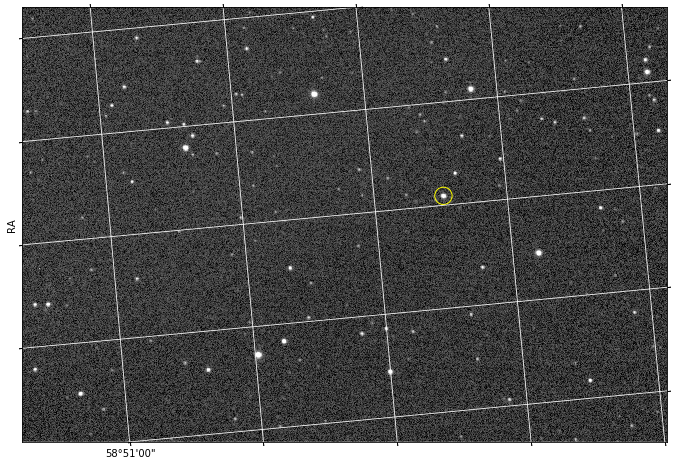

In [32]:
from matplotlib.colors import LogNorm

plt.figure(figsize=(14,8))
ax = plt.subplot(projection=wcs_info)
norm = LogNorm()
ax.imshow(first_data,cmap='Greys_r',norm=norm,vmin=downlim+10,vmax=uplim+1000)
ax.scatter(XXCygni.ra,XXCygni.dec,transform=ax.get_transform('fk5'), s=300,
           edgecolor='yellow', facecolor='none',label='XX Cygni')
# help from https://github.com/astropy/astropy/issues/7180
# the problem is the image has the RA axis 'up' as shown by the CD matrix.
ax.grid(color='white', ls='solid')

ax.coords['ra'].set_ticklabel_position('l')
ax.coords['dec'].set_ticklabel_position('b')

# RA still refers to the image x axis so switch the labels
ax.coords['ra'].set_axislabel('Dec') 
ax.coords['dec'].set_axislabel('RA')

#This puts the tick labels in the format hms and dms
ax.coords['ra'].set_major_formatter('hh:mm:ss')
ax.coords['dec'].set_major_formatter('dd:mm:ss')

# 4. Photometry with `photutils`

`photutils` is an `astropy` package for performing photometry in astronomical images. 
https://photutils.readthedocs.io/en/stable/

In [33]:
import photutils

## 4.1 Photometry using a general background estimation:

##### Estimating the background from simple statistics:

Looking to the image we just plotted, one may notice that most of the pixels in the image doesn't contain any star. Keeping that in mind, the simplest way of estimating the image background is by performing a sigma-clipping statistics for the image, which will remove the outliers (this is: the pixels that actually contain some stellar counting) and get some statistics out of the remaining pixels. There are several functions in `python` that can perform sigma clipping statistics, for example, we can use `sigma_clipped_stats` from `astrpy`:

In [34]:
from astropy.stats import sigma_clipped_stats
#help(sigma_clipped_stats)  #uncomment to see a description of the function

In [35]:
mean,median,std = sigma_clipped_stats(first_data,sigma=5.0)
print(mean,median,std)

121.39166740415142 121.16329284750337 23.40183159353192


It may be the case that the background of the image is highly variable, and in this case a sigma clipping statistics will not be a good estimator for it. When this is the case, `photutils` offers a series of tools for more robust background estimation. 

One of the options is to used the `Background2D` class to estimate a 2D background. This class offers tools to make a 2D model of the background in which a box of size x,y in pixels is define, the image is graded using x,y sizes and some statistics is made for estimating the background inside each box. 

Here is an example on how to estimate a 2D background:



In [36]:
#help(photutils.Background2D)  #uncomment to see a description of the function

Let's start by choosing a box size:

In [48]:
box=(7,7)

Then we need to inform the type of background estimator we want to use (you can see a more detailed description of the available types in: https://photutils.readthedocs.io/en/stable/background.html). We will use the `MedianBackground` one, which will estimate a sigma clipping median inside the boxes.

In [49]:
bkg_estimator = photutils.MedianBackground()

In [50]:
bkg = photutils.Background2D(first_data,box,bkg_estimator=bkg_estimator)

Just as comparison, we can get the median value of the 2d background model, which for the images we are working, is not very far from the values estimated from the sigma clipping statistics. 

In [51]:
bkg.background_median

120.82758620689656

The plot bellow is a comparison between the background 2D estimation and the raw image:

Text(0.5, 1.0, 'background')

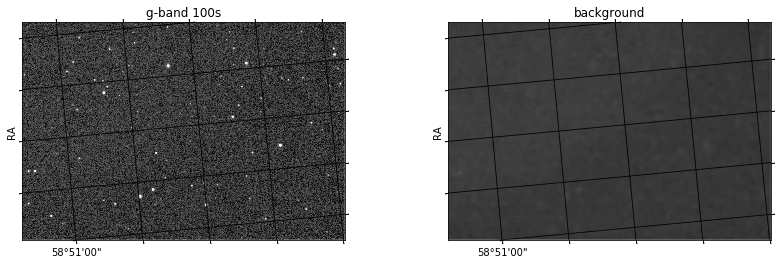

In [53]:
fig = plt.figure(figsize=(14,4))

ax = fig.add_subplot(1,2,1,projection=wcs_info)
norm = LogNorm()
ax.imshow(first_data,cmap='Greys_r',norm=norm,vmin=downlim+10, vmax=uplim+1000)
ax.grid(color='black', ls='solid')
ax.coords['ra'].set_ticklabel_position('l')
ax.coords['dec'].set_ticklabel_position('b')
ax.coords['ra'].set_axislabel('Dec') 
ax.coords['dec'].set_axislabel('RA')
ax.coords['ra'].set_major_formatter('hh:mm:ss')
ax.coords['dec'].set_major_formatter('dd:mm:ss')
ax.set_title(r'g-band 100s')

ax1 = fig.add_subplot(1,2,2,projection=wcs_info)
norm = LogNorm()
plt.imshow(bkg.background, origin='lower', cmap='Greys_r',norm=norm,vmin=downlim+10, vmax=uplim+1000)
ax1.grid(color='black', ls='solid')
ax1.coords['ra'].set_ticklabel_position('l')
ax1.coords['dec'].set_ticklabel_position('b')
ax1.coords['ra'].set_axislabel('Dec') 
ax1.coords['dec'].set_axislabel('RA')
ax1.coords['ra'].set_major_formatter('hh:mm:ss')
ax1.coords['dec'].set_major_formatter('dd:mm:ss')
ax1.set_title(r'background')

#### 4.1.1 with Source detection

We will use the `DAOStarFinder` class (which uses the Stetson 1987 DAOFIND algorithm) to detect stars in the image. 

In [54]:
#help(photutils.DAOStarFinder)  #uncomment to see a description of the function

We will need to input `DAOStarFinder` with at least two parameters:

- `fwhm`: Inform what is the full width at half maximum you expect a stellar source in your image to have (in pixels)
- `threshold`: Detection threshold above which sources are detected

In [67]:
daofind = photutils.DAOStarFinder(fwhm=3, 
                                  threshold=10.*bkg.background_rms_median)

Next, you provide the data with the background already subtracted:

In [68]:
sources = daofind.find_stars(first_data-bkg.background) 

Those are the sources we detected for the g-band:

In [69]:
sources.sort('mag')
for col in sources.colnames:  #this step simply improves table visualization
    sources[col].info.format = '%.8g' 
print(len(sources),sources[:10])

74  id xcentroid ycentroid sharpness  ... sky    peak      flux      mag    
--- --------- --------- ---------- ... --- --------- --------- ----------
 59 493.47685 588.41167 0.51322507 ...   0 25056.337 82.945274 -4.7969791
 12 399.14286 147.25128  0.4499111 ...   0 23340.162 71.091787 -4.6295486
 26 872.87802 319.84064 0.48319293 ...   0 15786.051 51.135683 -4.2718102
 41 276.14719 497.38773 0.51812619 ...   0 14414.516 49.187778  -4.229643
 61 757.66052 597.10997 0.48520353 ...   0 11131.702 38.835828 -3.9730814
 29 711.96024  415.9385 0.50192118 ...   0 7447.9157 25.623972 -3.5216161
 64 1055.8644 625.90526 0.51208425 ...   0 7444.4929 25.612858 -3.5211451
  7 621.92176 118.49433  0.4574523 ...   0 4488.4502 14.100401 -2.8730787
 13 442.59746  170.2571 0.53541383 ...   0 4885.1679 14.060581 -2.8700081
 21 43.869915 232.82852 0.48350135 ...   0 3376.2146 10.851705  -2.588745


And those are to output information `DAOStarFinder` provides us:

In [70]:
sources.keys()

['id',
 'xcentroid',
 'ycentroid',
 'sharpness',
 'roundness1',
 'roundness2',
 'npix',
 'sky',
 'peak',
 'flux',
 'mag']

You can see a description of each parameter in: https://photutils.readthedocs.io/en/stable/api/photutils.DAOStarFinder.html#photutils.DAOStarFinder

Note that in this step, the information we want to get is the detector positions for the sources. The magnitudes provided here are not yet the magnitude we want measured - it is just a simple instrumental magnitude measurement estimated as $-2.5\log_{10}$(`flux`) and it doesn't take any consideration for exposure time and other parameters.

Even though they are not the final flux/magnitude estimation, they are useful to get rid of saturated sources. By using a saturation limit of 50000 (Jenny told me this comes from the ccd documentation), we can proceed by keeping only unsaturated objects:

In [71]:
saturated=50000
positions = (sources['xcentroid'][sources['peak']<saturated],sources['ycentroid'][sources['peak']<saturated])
len(positions[0])

74

#### Aperture Photomettry

Next, to perform aperture photometry, we first have to define an aperture. We will use a `CircularAperture`, and we need to inform the function what are the positions for the apertures, and what is the radius of the aperture. I will use an aperture with radius of 4.0 pixels.

In [72]:
apertures=photutils.CircularAperture(positions,r=6.)

The plot bellow shows the position of the apertures to be used in the photometric extraction. You can play with the parameters used `photutils.CircularAperture` and `photutils.DAOStarFinder` and use the plot bellow to verify how to improve the detections. Note also that the brighter stars are not detected due to the saturation limit imposed.

Text(0.5, 1.0, 'r-band 100s')

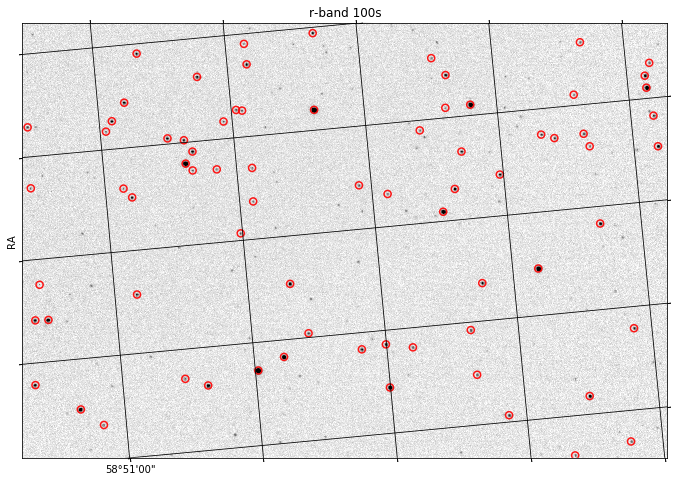

In [74]:

plt.figure(figsize=(14,8))
ax = plt.subplot(projection=wcs_info)
norm = LogNorm()
#Not that the `_r` in the cmap name reverts the color-table. 
ax.imshow(first_data,cmap='Greys',norm=norm,vmin=downlim+10, vmax=uplim+1000)
apertures.plot(color='r',alpha=0.9,lw=1.5)

# help from https://github.com/astropy/astropy/issues/7180
# the problem is the image has the RA axis 'up' as shown by the CD matrix.
ax.grid(color='black', ls='solid')

# We need to set the ticklabel position explicitly

ax.coords['ra'].set_ticklabel_position('l')
ax.coords['dec'].set_ticklabel_position('b')

# RA still refers to the image x axis so switch the labels
ax.coords['ra'].set_axislabel('Dec') 
ax.coords['dec'].set_axislabel('RA')

ax.coords['ra'].set_major_formatter('hh:mm:ss')
ax.coords['dec'].set_major_formatter('dd:mm:ss')

ax.set_title(r'r-band 100s')

Because we want to have the photometry and the sky coordinates, we need too define the apertures in terms of sky coordinates:

In [75]:
apertures_sky = apertures.to_sky(wcs_info)

Finally we can use `aperture_photometry` to perform photometric extraction. Note that we have to provide the data with the sky subtracted, the apertures in sky coordinates, and we also need to provide the WCS information.

In [77]:
phot_table = photutils.aperture_photometry(first_data-bkg.background,
                                            apertures_sky,wcs=wcs_info)

In [79]:
phot_table

id,xcenter,ycenter,sky_center,aperture_sum
,pix,pix,"deg,deg",
int64,float64,float64,object,float64
1,493.4768451123593,588.4116721018662,"300.70288703433414,59.0099242368854",317890.74089777615
2,399.14286420595545,147.25127978260133,"300.62777561899617,58.88637390597342",348350.275101488
3,872.8780160884976,319.8406362940788,"300.8989571445923,58.922787294789266",207766.3867945064
4,276.1471872248687,497.3877291103025,"300.5775936056788,58.98972430956639",165675.13590442747
5,757.6605221414868,597.1099652174224,"300.85004007411146,59.00521854308002",134524.19529760972
6,711.9602395285024,415.9385034783688,"300.81495103576,58.954646319398535",88777.62727046621
7,1055.8644283206029,625.9052580960134,"301.0172936560922,59.00523593642596",89311.76068015941
8,621.9217647298293,118.49432681530132,"300.7494027159719,58.87216555057705",68345.89850863669


In [80]:
phot_table.keys()

['id', 'xcenter', 'ycenter', 'sky_center', 'aperture_sum']

#### Instrumental Magnitudes and Coordinates

The instrumental magnitude can be estimated as:

$$m_\mathrm{inst}=-2.5\log_{10}\Bigg[\frac{\sum^n_{i=1}C_i}{t}\Bigg]$$

In [81]:
# add uncalibrated magnitude scale
time=float(first_head['EXPTIME'])
mag_inst=-2.5*np.log10(phot_table['aperture_sum']/time)

The distribution below shows the g magnitude of the sources detected:

Text(0.5, 0, 'mag_inst')

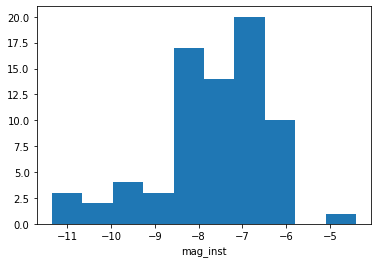

In [83]:
histogram = plt.hist(mag_inst, bins='auto')
plt.xlabel('mag_inst')

Finally, notice that the `sky_center` field, gives the coordinate of the detected star:

In [84]:
coords = phot_table['sky_center']
coords[:10].ra

<Longitude [300.70288703, 300.62777562, 300.89895714, 300.57759361,
            300.85004007, 300.81495104, 301.01729366, 300.74940272,
            300.65297182, 300.43570654] deg>

### 4.1.2 performing photometry on fixed apertures:

Instead of performing source detection, it can be more interesting to perform photometric extraction directly in the position of stars.

As an example, I used `TOPCAT` to download a table from the APASS catalogue(https://www.aavso.org/apass) in the FOV of XXCygni, and I saved this catalogue as (`apass_xxcygni_FOV.fits`)

To open this cataloge, I can use `astropy.table` (https://docs.astropy.org/en/stable/table/):

In [86]:
from astropy.table import Table

In [271]:
filename='apass_xxcygni_FOV.fits'
data_apass=Table.read(mymasterdir+workingdir+filename, format='fits') 

In [272]:
repr(data_apass.keys())

"['objID', 'ra', 'dec', 'raerr', 'decerr', 'Vmag', 'B_V', 'Bmag', 'gmag', 'rmag', 'imag', 'Verr', 'B_Verr', 'Berr', 'gErr', 'rErr', 'iErr', 'nObsNights', 'nObsImages', 'Field', 'mag']"

I was given some background information from Sean and Sasha, that usually only the brightest stars will have photometry with quality high enough to be used in the project. Based on that, I will keep in my list of reference stars, only those with rmag<13 mag

In [273]:
print('before excluding fainter stars',len(data_apass))

before excluding fainter stars 151


In [274]:
data_apass=data_apass[data_apass['rmag']<13.]

In [275]:
print('after excluding fainter stars',len(data_apass))

after excluding fainter stars 21


Now we can use `SkyCoord` to build a coordinate catalogue with these reference stars:

In [276]:
from astropy.coordinates import SkyCoord
from astropy import units as u

In [277]:
apas_reference=SkyCoord(data_apass['ra'],data_apass['dec'],unit="deg")

In [278]:
apas_reference

<SkyCoord (ICRS): (ra, dec) in deg
    [(300.815059, 58.954591), (300.850245, 59.005248),
     (300.899146, 58.922672), (300.702903, 59.009947),
     (300.665047, 58.926704), (300.749516, 58.87205 ),
     (300.65284 , 58.891637), (301.022564, 58.976227),
     (300.935303, 58.858714), (301.022759, 58.914343),
     (301.017142, 59.005073), (300.955092, 59.045291),
     (301.016827, 59.010645), (300.627681, 58.886293),
     (301.026158, 58.890699), (300.577558, 58.989646),
     (300.57929 , 58.881268), (300.435467, 58.920085),
     (300.458402, 58.875463), (300.42379 , 58.920437),
     (300.417972, 58.88922 )]>

Finally, in this plot I am showing in red circles, the positions of the reference stars, and in yellow I am showing the position of XXCygni.

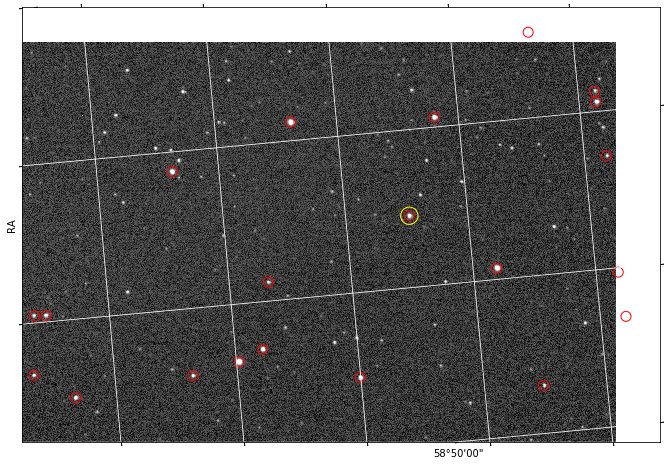

In [279]:
from matplotlib.colors import LogNorm

plt.figure(figsize=(14,8))
ax = plt.subplot(projection=wcs_info)
norm = LogNorm()
ax.imshow(first_data,cmap='Greys_r',norm=norm,vmin=downlim+10,vmax=uplim+1000)
ax.scatter(XXCygni.ra,XXCygni.dec,transform=ax.get_transform('fk5'), s=300,
           edgecolor='yellow', facecolor='none',label='XX Cygni')
ax.scatter(apas_reference.ra,apas_reference.dec,transform=ax.get_transform('fk5'), s=100,
           edgecolor='red', facecolor='none',label='Apass')
# help from https://github.com/astropy/astropy/issues/7180
# the problem is the image has the RA axis 'up' as shown by the CD matrix.
ax.grid(color='white', ls='solid')

ax.coords['ra'].set_ticklabel_position('l')
ax.coords['dec'].set_ticklabel_position('b')

# RA still refers to the image x axis so switch the labels
ax.coords['ra'].set_axislabel('Dec') 
ax.coords['dec'].set_axislabel('RA')

#This puts the tick labels in the format hms and dms
ax.coords['ra'].set_major_formatter('hh:mm:ss')
ax.coords['dec'].set_major_formatter('dd:mm:ss')

We can use the coordinate catalogue to define the positions of the apertures. 

In [280]:
apertures=photutils.SkyCircularAperture(apas_reference, r=4. * u.arcsec)

In [281]:
phot_table = photutils.aperture_photometry(first_data-bkg.background,
                                            apertures,wcs=wcs_info)

In [282]:
phot_table.keys()

['id', 'xcenter', 'ycenter', 'sky_center', 'aperture_sum']

In [283]:
# add uncalibrated magnitude scale
time=float(first_head['EXPTIME'])
mag_inst=-2.5*np.log10(phot_table['aperture_sum']/time)

In [284]:
len(mag_inst)

21

We can use the input catalogue from APASS to do a quick callibration to the data.

First, let's double check the filter with which we are working

In [285]:
first_head['FILTER']

'Sloanr'

In [286]:
delta_r=data_apass['rmag']-mag_inst
offset=np.nanmedian(delta_r)
print(offset)

21.087322640521087


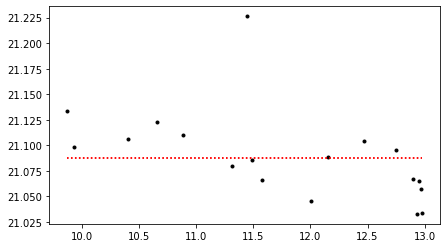

In [287]:
plt.figure(figsize=(7,4))
plt.plot(data_apass['rmag'],delta_r,'k.')
plt.plot([np.min(data_apass['rmag']),np.max(data_apass['rmag'])],[offset,offset],'r:')
plt.plot([np.min(data_apass['rmag']),np.max(data_apass['rmag'])],[offset,offset],'r:')

In [288]:
mag=mag_inst+offset

/Users/jroquette/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:403: RuntimeWarning: invalid value encountered in greater_equal
  keep = (a >= first_edge)
/Users/jroquette/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:404: RuntimeWarning: invalid value encountered in less_equal
  keep &= (a <= last_edge)
/Users/jroquette/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/jroquette/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 0, 'r mag')

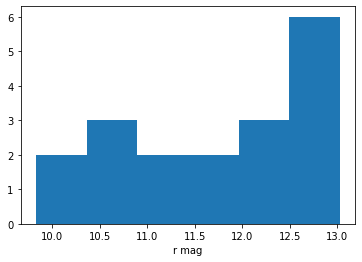

In [289]:
histogram = plt.hist(mag, bins='auto')
plt.xlabel('r mag')

Just FYI: Depending on the filter, you could try to get magnitudes from Simbad.

In [290]:
from astroquery.simbad import Simbad
customSimbad = Simbad()
customSimbad.add_votable_fields('flux(r)')
XXCygni_Simbad = customSimbad.query_object("XX Cygni")

In [291]:
XXCygni_Simbad

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,FLUX_r
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,mag
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object,float32
V* XX Cyg,20 03 15.6422,+58 57 16.525,14,14,0.042,0.037,90,A,O,2018yCat.1345....0G,--


## 4.2 Photometry using a local background estimation:

Instead of using a general background estimation, we could have used an local one.

For example, we can keep the same apertures from the previous example:

In [292]:
apertures=photutils.SkyCircularAperture(apas_reference, r=4. * u.arcsec)

And additionally define an circular annulus around the stars, for example, this defines annulus that have internal radii `r_in=6`'' and external radii `r_out=8`''

In [293]:
annulus= photutils.SkyCircularAnnulus(apas_reference, r_in=6.* u.arcsec, r_out=8.* u.arcsec)

Note however that this mode will only work in terms of pixel coordinates, so we need to convert it back to pixels!

In [294]:
annulus_=annulus.to_pixel(wcs_info)

In [295]:
apertures_=apertures.to_pixel(wcs_info)

First, as an example, let's consider a single aperture around XXCygni:

In [296]:
xxcygni_aperture_sky=photutils.SkyCircularAperture(XXCygni, r=4. * u.arcsec)
xxcygni_annulus_sky= photutils.SkyCircularAnnulus(XXCygni, r_in=6.* u.arcsec, r_out=8.* u.arcsec)

In [297]:
xxcygni_aperture=xxcygni_aperture_sky.to_pixel(wcs_info)
xxcygni_annulus=xxcygni_annulus_sky.to_pixel(wcs_info)

(700, 730)

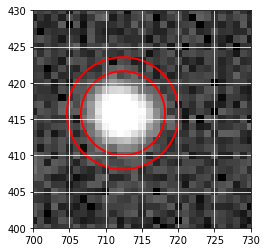

In [298]:
from matplotlib.colors import LogNorm

plt.figure(figsize=(7,4))
ax = plt.subplot()
norm = LogNorm()
ax.imshow(first_data,cmap='Greys_r',norm=norm,vmin=downlim+10,vmax=uplim+1000)

xxcygni_annulus.plot(color='red', lw=2)

ax.grid(color='white', ls='solid')
ax.set_ylim(400,430)
ax.set_xlim(700,730)

#### 4.2.1 Simple Mean background:

`photutils` default will be to extract background locally by using a simple mean.

First, we need to put aperture and annulus together in a `list`:

In [419]:
apers = [apertures_, annulus_]

Next, we can pass those to `photutils.aperture_photometry`:

In [420]:
phot_table = photutils.aperture_photometry(first_data, apers,wcs=wcs_info)

In [421]:
phot_table[0:10]

id,xcenter,ycenter,aperture_sum_0,aperture_sum_1
,pix,pix,,
int64,float64,float64,float64,float64
1,712.1830140238516,415.78737365949564,87571.7578538202,11689.343745710226
2,758.027466163243,597.269109040768,128984.95005899318,13226.17039710983
3,873.2661522914275,319.4953593882049,196681.3320243053,14450.301130134694
4,493.50919560207535,588.5153500938839,297884.06125135685,16994.2312767587
5,452.9477778806949,293.60040477564814,27438.79206453918,10429.529766188205
6,622.1742698545562,118.13434569288188,68292.00038633394,11309.470051189099
7,442.41598269663933,169.7885616171625,75284.05420085334,11617.682477830664
8,1075.342292925162,526.4147168940864,22709.3997315234,10025.905706372138


Note that the output table now has two fields `aperture_sum`. `aperture_sum_0` refers to the aperture itself, and `aperture_sum_1` refers to the annulus.

To estimate the local background, we need to divide the count in the annulus by the annulus area:

In [422]:
bkg_mean = phot_table['aperture_sum_1'] / annulus_.area

In [423]:
print(bkg_mean[0:5])

  aperture_sum_1  
------------------
142.20963838296706
160.90628783628205
175.79875679467224
206.74757600068554
126.88305595413047


The background inside the apperture itself, will be this `bkg_mean` value, times the apperture area:

In [424]:
bkg_sum = bkg_mean * apertures_.area

Finally, we can add a new field in the table, that I will call `star_aperture_sum` and which will contain the star counts subtracted by the background:

In [425]:
phot_table['star_aperture_sum']=phot_table['aperture_sum_0']-bkg_sum

In [426]:
phot_table

id,xcenter,ycenter,aperture_sum_0,aperture_sum_1,star_aperture_sum
,pix,pix,,,
int64,float64,float64,float64,float64,float64
1,712.1830140238516,415.78737365949564,87571.7578538202,11689.343745710226,80892.1328562715
2,758.027466163243,597.269109040768,128984.95005899318,13226.17039710983,121427.13840350186
3,873.2661522914275,319.4953593882049,196681.3320243053,14450.301130134694,188424.01709279977
4,493.50919560207535,588.5153500938839,297884.06125135685,16994.2312767587,288173.0719503519
5,452.9477778806949,293.60040477564814,27438.79206453918,10429.529766188205,21479.06076957449
6,622.1742698545562,118.13434569288188,68292.00038633394,11309.470051189099,61829.44607136874
7,442.41598269663933,169.7885616171625,75284.05420085334,11617.682477830664,68645.37849923581
8,1075.342292925162,526.4147168940864,22709.3997315234,10025.905706372138,16980.310756453608


Note that the `nan` values are sources in the APASS catalogue that are outside my image FOV. 

## 4.2.2 Need a more robust background?

For future reference in the extended experiment, when we have more crowded fields, we will probably need a background estimator more robust than the simple median. Towards that, I will make an example of how to estimate local background using **sigma clipped median**.

It is possible to directly access the pixel values inside the aperture by creating a mask with the annulus. For example, I will use the apperture and annulus I created around XX Cygni.

In [427]:
annulus_masks = xxcygni_annulus.to_mask(method='center')

This will apply this mask in the data:

In [428]:
annulus_masked = annulus_masks.multiply(first_data)

Such as we are left only with the pixel counts inside the mask:

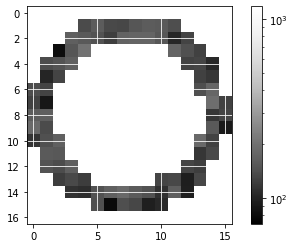

In [429]:
from matplotlib.colors import LogNorm

plt.figure(figsize=(7,4))
ax = plt.subplot()
norm = LogNorm()
plt.imshow(annulus_masked,cmap='Greys_r',norm=norm,vmin=downlim+10,vmax=uplim+1000)

#annulus_.plot(color='red', lw=2)

ax.grid(color='white', ls='solid')
plt.colorbar()

To estimate the background, we could then extract the counts:

In [430]:
mask=annulus_masks.data
annulus_data=annulus_masked[mask>0]
annulus_data.shape

(87,)

In [431]:
_, median_sigclip, _ =sigma_clipped_stats(annulus_data,sigma=5.0)

Finally, the background will be:

In [432]:
bkg_annulus=median_sigclip*xxcygni_aperture.area
print(bkg_annulus)

6472.00361628497


For applying this to all sources:

In [433]:
annulus_masks_=annulus_.to_mask(method='center')

In [434]:
bkg_median = []
for a in annulus_:
    annulus_masks=a.to_mask(method='center')
    annulus_masked = annulus_masks.multiply(first_data)   
    mask=annulus_masks.data
    if isinstance(annulus_masked, type(None)): # test if there is data!
        bkg_median.append(np.nan)
    else:
        annulus_data=annulus_masked[mask>0]    
        _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
        bkg_median.append(median_sigclip)
bkg_median = np.array(bkg_median)

In [435]:
phot = photutils.aperture_photometry(first_data, apertures_)
phot

id,xcenter,ycenter,aperture_sum
,pix,pix,
int64,float64,float64,float64
1,712.1830140238516,415.78737365949564,87571.7578538202
2,758.027466163243,597.269109040768,128984.95005899318
3,873.2661522914275,319.4953593882049,196681.3320243053
4,493.50919560207535,588.5153500938839,297884.06125135685
5,452.9477778806949,293.60040477564814,27438.79206453918
6,622.1742698545562,118.13434569288188,68292.00038633394
7,442.41598269663933,169.7885616171625,75284.05420085334
8,1075.342292925162,526.4147168940864,22709.3997315234


In [437]:
phot['annulus_median'] = bkg_median
phot['aper_bkg'] = bkg_median * apertures_.area
phot['star_aperture_sum']=phot['aperture_sum'] - phot['aper_bkg']

In [438]:
phot

id,xcenter,ycenter,aperture_sum,annulus_median,aper_bkg,star_aperture_sum
,pix,pix,,,,
int64,float64,float64,float64,float64,float64,float64
1,712.1830140238516,415.78737365949564,87571.7578538202,151.26416295353278,7104.918454097659,80466.83939972255
2,758.027466163243,597.269109040768,128984.95005899318,151.26416295353278,7104.918454097659,121880.03160489553
3,873.2661522914275,319.4953593882049,196681.3320243053,151.26416295353278,7104.918454097659,189576.41357020763
4,493.50919560207535,588.5153500938839,297884.06125135685,151.26416295353278,7104.918454097659,290779.1427972592
5,452.9477778806949,293.60040477564814,27438.79206453918,151.26416295353278,7104.918454097659,20333.87361044152
6,622.1742698545562,118.13434569288188,68292.00038633394,151.26416295353278,7104.918454097659,61187.08193223628
7,442.41598269663933,169.7885616171625,75284.05420085334,151.26416295353278,7104.918454097659,68179.13574675568
8,1075.342292925162,526.4147168940864,22709.3997315234,151.26416295353278,7104.918454097659,15604.48127742574


### 4.2.3 Adding Uncertainty

By propagating the uncertainty in the flux to the definition of magnitude: 

$mag_{err}=\frac{2.5}{\ln(10)}\frac{flux_{err}}{flux}$

So the goal here is to estimate  `flux_err`, considering the uncertainties in the ccd, and flux and background estimations

`photoutils` can propagate the uncertainties per pixel to the flux, but for that you need to inform the uncertainty per pixel. As I don't know this information, I will simply do an example assuming the uncertainty per pixel is 0.001

In [539]:
error = 0.01 * first_data

In [540]:
phot_table = photutils.aperture_photometry(first_data, apers,wcs=wcs_info,error=error)

In [541]:
phot_table[0:10]

id,xcenter,ycenter,aperture_sum_0,aperture_sum_err_0,aperture_sum_1,aperture_sum_err_1
,pix,pix,,,,
int64,float64,float64,float64,float64,float64,float64
1,712.1830140238516,415.78737365949564,87571.7578538202,174.66485916472118,11689.343745710226,13.126680422129773
2,758.027466163243,597.269109040768,128984.95005899318,264.8370620233298,13226.17039710983,14.873771367998925
3,873.2661522914275,319.4953593882049,196681.3320243053,390.8632000353216,14450.301130134694,16.25474675047802
4,493.50919560207535,588.5153500938839,297884.06125135685,626.4899316634366,16994.2312767587,19.525022948299796
5,452.9477778806949,293.60040477564814,27438.79206453918,50.74125181318361,10429.529766188205,11.657039510603322
6,622.1742698545562,118.13434569288188,68292.00038633394,127.12711819148547,11309.470051189099,12.68183346483351
7,442.41598269663933,169.7885616171625,75284.05420085334,142.76633844941227,11617.682477830664,13.002452639634555
8,1075.342292925162,526.4147168940864,22709.3997315234,41.20576067178763,10025.905706372138,11.3332700548581


In [542]:
bkg_mean = phot_table['aperture_sum_1'] / annulus_.area

In [543]:
bkg_sum = bkg_mean * apertures_.area
phot_table['bkg_sum']=bkg_sum

In [544]:
phot_table['star_aperture_sum']=phot_table['aperture_sum_0']-phot_table['bkg_sum']

In [545]:
phot_table[0:10]

id,xcenter,ycenter,aperture_sum_0,aperture_sum_err_0,aperture_sum_1,aperture_sum_err_1,bkg_sum,star_aperture_sum
,pix,pix,,,,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64
1,712.1830140238516,415.78737365949564,87571.7578538202,174.66485916472118,11689.343745710226,13.126680422129773,6679.6249975487,80892.1328562715
2,758.027466163243,597.269109040768,128984.95005899318,264.8370620233298,13226.17039710983,14.873771367998925,7557.811655491331,121427.13840350186
3,873.2661522914275,319.4953593882049,196681.3320243053,390.8632000353216,14450.301130134694,16.25474675047802,8257.314931505538,188424.01709279977
4,493.50919560207535,588.5153500938839,297884.06125135685,626.4899316634366,16994.2312767587,19.525022948299796,9710.98930100497,288173.0719503519
5,452.9477778806949,293.60040477564814,27438.79206453918,50.74125181318361,10429.529766188205,11.657039510603322,5959.731294964688,21479.06076957449
6,622.1742698545562,118.13434569288188,68292.00038633394,127.12711819148547,11309.470051189099,12.68183346483351,6462.5543149651985,61829.44607136874
7,442.41598269663933,169.7885616171625,75284.05420085334,142.76633844941227,11617.682477830664,13.002452639634555,6638.6757016175225,68645.37849923581
8,1075.342292925162,526.4147168940864,22709.3997315234,41.20576067178763,10025.905706372138,11.3332700548581,5729.0889750697925,16980.310756453608


I assumed that `annulus_.area` and `aperture.area` are both exact, and propagated the uncertainty in `aperture_sum_1` to `bkg_sum`: $$\verb|bkg_sum_err|=\verb|aperture_sum_err_1|\times\frac{\verb|apertures_.area|}{\verb|annulus_.area|}$$

In [546]:
phot_table['bkg_sum_err']=phot_table['aperture_sum_err_1']*(apertures_.area/annulus_.area)

Next, I propagated the uncertainties to `star_aperture_sum`:

$$\verb|star_aperture_sum_err|=\sqrt{(\verb|aperture_sum_err_0|)^2+(\verb|aperture_sum_err_1|\times\frac{\verb|apertures_.area|}{\verb|annulus_.area|})^2}$$

In [547]:
phot_table['star_aperture_sum_err']=np.sqrt((phot_table['aperture_sum_err_0']**2)+(phot_table['aperture_sum_err_1']*(apertures_.area/annulus_.area))**2)

In [548]:
phot_table

id,xcenter,ycenter,aperture_sum_0,aperture_sum_err_0,aperture_sum_1,aperture_sum_err_1,bkg_sum,star_aperture_sum,bkg_sum_err,star_aperture_sum_err
,pix,pix,,,,,,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,712.1830140238516,415.78737365949564,87571.7578538202,174.66485916472118,11689.343745710226,13.126680422129773,6679.6249975487,80892.1328562715,7.500960241217013,174.82584886558453
2,758.027466163243,597.269109040768,128984.95005899318,264.8370620233298,13226.17039710983,14.873771367998925,7557.811655491331,121427.13840350186,8.499297924570813,264.97340901750806
3,873.2661522914275,319.4953593882049,196681.3320243053,390.8632000353216,14450.301130134694,16.25474675047802,8257.314931505538,188424.01709279977,9.288426714558868,390.9735489936417
4,493.50919560207535,588.5153500938839,297884.06125135685,626.4899316634366,16994.2312767587,19.525022948299796,9710.98930100497,288173.0719503519,11.157155970457026,626.5892726539503
5,452.9477778806949,293.60040477564814,27438.79206453918,50.74125181318361,10429.529766188205,11.657039510603322,5959.731294964688,21479.06076957449,6.66116543463047,51.1766134139064
6,622.1742698545562,118.13434569288188,68292.00038633394,127.12711819148547,11309.470051189099,12.68183346483351,6462.5543149651985,61829.44607136874,7.246761979904862,127.33349810189505
7,442.41598269663933,169.7885616171625,75284.05420085334,142.76633844941227,11617.682477830664,13.002452639634555,6638.6757016175225,68645.37849923581,7.429972936934031,142.95954634824395
8,1075.342292925162,526.4147168940864,22709.3997315234,41.20576067178763,10025.905706372138,11.3332700548581,5729.0889750697925,16980.310756453608,6.476154317061771,41.711572582186804


Finally, this was our estimation of `mag_inst`:

In [549]:
# add uncalibrated magnitude scale
time=float(first_head['EXPTIME'])
mag_inst=-2.5*np.log10(phot_table['star_aperture_sum']/time)

In [550]:
e_mag_inst=(2.5/np.log(10))*(phot_table['star_aperture_sum_err']/phot_table['star_aperture_sum'])

In [551]:
e_mag_inst

0.0023465168606469976
0.0023692498007529088
0.002252866400975347
0.0023607710957485456
0.0025869055735945694
0.0022359991517334242
0.0022611333592954725
0.002667075129509305
0.002580148195435346
nan
0.0023747878422960547
